### Preparing the notebook

In [2]:
from utilities.helpers import check

check()

Tensorflow version 	= 1.7 [ok]
Keras version 		= 2.1 [ok]
OpenCV version 		= 3.3 [ok]

1 GPU detected


In [3]:
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt 
%matplotlib inline

In [4]:
from utilities.helpers import Time

In [5]:
# # # Jupyter will automaticaly reload libraries if they have been modified
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

---

# Table of Contents
---
- **Data**
    - Loading and pre-processing the dataset
    - Visualizing the dataset
    
- **Training/Loading the model**
- **Evaluating the model**
- **Results**
    - Predictions
    - Generating the Class Activation Maps
- **Extending the dataset with images scraped from Google image**

# 1. Data
---

## Loading and pre-processing the dataset

The data used to train the classifier comes from the [INRIA person dataset](http://pascal.inrialpes.fr/data/human/).

This dataset contains images with and without persons.

Loading the data ...
- ... transforms images into a 4D tensor of shape `(samples_size, 224, 224, 3)` suitable for supplying to a Keras CNN
- ... transforms class labels into one hot encoded labels.
- ... creates a validation folder using 20% of the original training data (The INRIA person dataset originaly doesn't contain validation data)
- ... balances the data: originaly, there are 1669 negatives and 900 positives which means that the model could reach an accuracy of 70% by always predicting negatives. We therefore do not load the excess of negatives.

The training tensors and labels can be accessed as follows:
```
data.X_train
data.y_train
```
Same goes for the validation and testing data (`X_valid`, `y_test` etc.)

In [7]:
from utilities import datasets

data = datasets.InriaPersonDataset("INRIAPerson")

100%|██████████| 384/384 [00:04<00:00, 83.52it/s]


## Visualizing the dataset

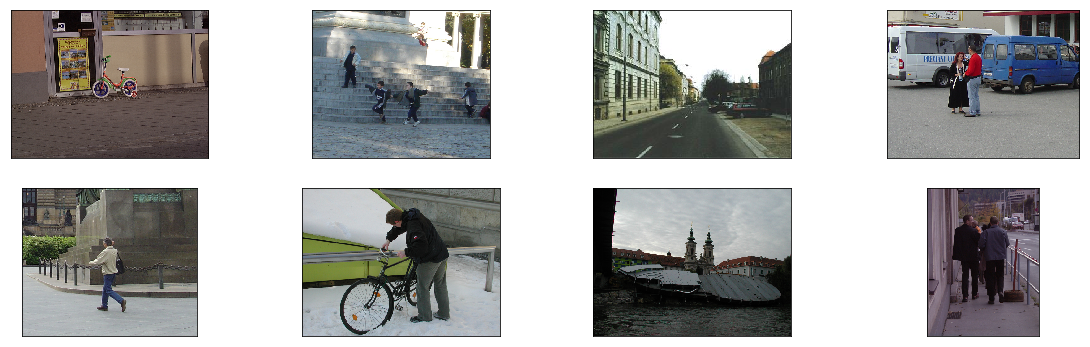

In [8]:
data.examples(sample="Test", number=8)

In [9]:
data.classes

['neg', 'pos']

In [10]:
data.statistics()

,neg,pos,Total
Classes,,,
Train,415,423,838
Valid,195,189,384
Test,226,288,514
,836,900,1736


# 2.  Training the model
---

### Model

In [11]:
from utilities.gapModels import MobileNetGAP

The `MobileNetGAP` class can be used just as any **compiled** Keras model (`keras.models`). 

This model is a the MobileNet model, top not included, that ends with a GlobalAveragePooling layer, followed by a dense layer with as many neurones as there are classes in the dataset.

The ConvNet layers of the model have been pretrained on the [ImageNet](http://image-net.org) dataset.

We will perform **transfert learning** by training the dense layer and retraining only the last two convnet layers (as the database is quite small).

Once trained it will be possible to load the model by simply calling:
```
model = MobileNetGAP(path='saved_model/mobilenet.h5')
```

Let's now create the compiled model:

In [12]:
model = MobileNetGAP(nb_classes=len(data.classes))

### Classifier

In [13]:
from utilities.classifier import Classifier

To train the model and save it, we will create an instance of the `Classifier` class.


A classifier takes as parameter a model, preferably built with a subclass of `AbstractModelGAP` (see `./utilities/gapModels.py`) as this will make the generation of CAMs easier.

Classifiers can be fitted to a dataset (which will train the model given as parameter).

Once fitted, they can be used to predict the class of an image or to generate **Class Activation Maps** (CAM)

Classifiers can also be used with a pretrained model loaded with `MobileNetGAP(path)`. They then can, but don't need to be fitted again to generate predictions/CAMs.


In [353]:
clf = Classifier(model, name='mobilenet')

clf.fit(data, epochs=100, batch_size=64, augmentation=True, verbose=1)

Epoch 1/100
13/13 [==============================] - 9s 699ms/step - loss: 0.0119 - acc: 1.0000 - val_loss: 0.0429 - val_acc: 0.9866
Epoch 2/100
13/13 [==============================] - 9s 658ms/step - loss: 0.0103 - acc: 1.0000 - val_loss: 0.0426 - val_acc: 0.9893
Epoch 3/100
13/13 [==============================] - 9s 673ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0452 - val_acc: 0.9893
Epoch 4/100
13/13 [==============================] - 8s 646ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0455 - val_acc: 0.9893
Epoch 5/100
13/13 [==============================] - 8s 620ms/step - loss: 0.0135 - acc: 0.9988 - val_loss: 0.0443 - val_acc: 0.9893
Epoch 6/100
13/13 [==============================] - 8s 607ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.0420 - val_acc: 0.9920
Epoch 7/100
13/13 [==============================] - 8s 596ms/step - loss: 0.0101 - acc: 1.0000 - val_loss: 0.0443 - val_acc: 0.9920
Epoch 8/100
13/13 [==============================] - 8s 634ms/step - 

# 3.  Evaluating the model
---

Let's visualise the learning curves:

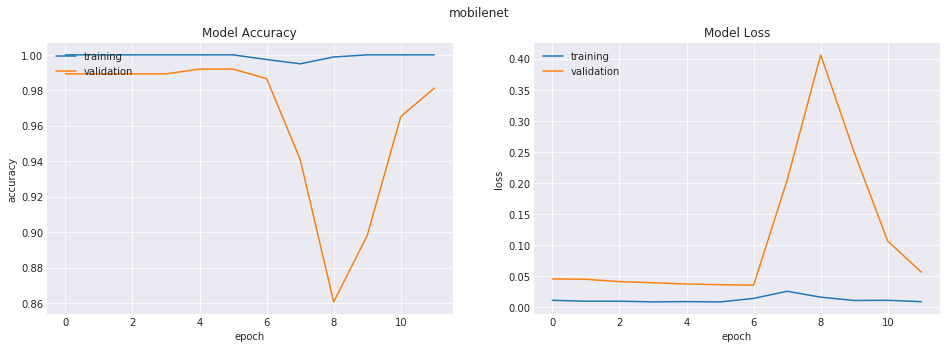

In [350]:
clf.learning_curves()

>These can also be visualized with Tensorboar:
```
tensorboard --logdir=./tensorboard_logs
```
The Tensorboard page can then be found on port `6006`  

We get the following results on the test set:

In [351]:
loss, acc = model.evaluate(data.X_test, data.y_test)

515/515 [==============================] - 1s 3ms/step


In [352]:
print("Loss     : {:.2%}\nAccuracy : {:.2%}".format(loss, acc))

Loss     : 12.78%
Accuracy : 94.76%


# 4. Results
---

Let's view the results for an exemple:

In [247]:
test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
test_image_path

'INRIAPerson/Test/pos/crop001661.png'

In [248]:
test_img = cv2.imread(test_image_path, 1)

## Predictions

We can choose to allow the classifier to make a descision on the class or to just show the probabilities:

In [251]:
with Time() as runtime:
    prediction = clf.predict(test_img, decision=False)

print("Prediction     :", prediction)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

Prediction     : [0.0048041316, 0.9951958]
Execution time : 14.608ms


The model got the class right.

## Generating the Class Activation Maps

In [252]:
# Here we could import a previously saved model
# model = MobileNetGAP(path='saved_model/mobilenet.h5')
# clf = Classifier(model, name='mobilenet')

We can now view the regions that allowed the model to estimate the class probabilities:

Execution time : 45.591ms


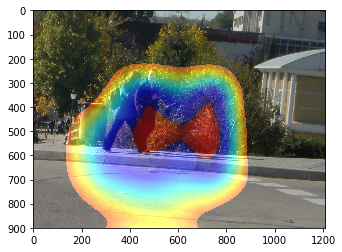

In [254]:
with Time() as runtime:
    cam, prediction = clf.cam(test_img, class_number=1)
    
plt.imshow(cam)
print('Execution time : {:.3f}ms'.format(1000*runtime()))

The CAM generation is quite fast 😎

Let's do that for a few other images:

In [305]:
def cam():
    """
    cam for a random image
    """
    with Time() as runtime:
        test_image_path = np.random.choice(glob("INRIAPerson/Test/*/*"))
        test_img        = cv2.imread(test_image_path, 1)
        cam, prediction = clf.cam(test_img, class_number=1)
    
    print('Execution time : {:.3f}ms'.format(1000*runtime()))
    print("Prediction     :", data.classes[np.argmax(prediction)])
    plt.imshow(cam)

Execution time : 34.451ms
Prediction     : neg


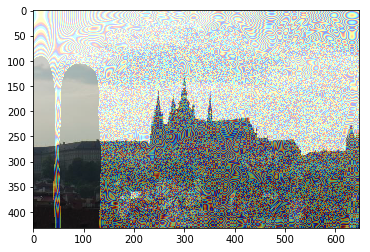

In [256]:
cam()

Execution time : 42.599ms
Prediction     : neg


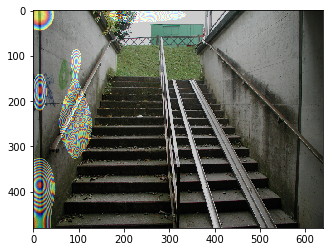

In [257]:
cam()

Execution time : 48.638ms
Prediction     : pos


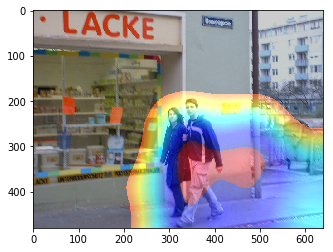

In [258]:
cam()

# 5. Extending the dataset with images scraped from Google image

With the INRIA person dataset, the model overfits after a few iteration (~10). Moreover this dataset is limited and there are no close-up images for example. Therefore, the model doesn't perform well when presented with the image of a face. 

Let's add more images to this dataset.

In [15]:
from utilities import datasets

In [20]:
data_gi = datasets.GoogleImageScrapedDataset("googleImage")

In [50]:
for keyword in ["room", "empty street", "animals", "forest", "house", "ghost town", "kitchen", "empty corridor"]:
    data_gi.fillClass(class_name="neg", sample_size=100, keywords=[keyword], valid=0.2, test=0.2)
    
for keyword in ["woman", "man", "room with people", "person in street", "people in webcam", "girl", "boy", "dancer"]:
    data_gi.fillClass(class_name="pos", sample_size=100, keywords=[keyword], valid=0.2, test=0.2)

In [33]:
data_gi.load()

100%|██████████| 283/283 [00:03<00:00, 81.53it/s]


In [ ]:
data_gi.examples(sample="Train", number=8)

In [25]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,408,414,822
Valid,145,138,283
Test,143,150,293
,696,702,1398


Let's now add to this new dataset, the imgages from the INRIA person dataset

In [31]:
data_gi.merge(data)

In [32]:
data_gi.statistics()

,neg,pos,Total
Classes,,,
Train,1238,1260,2498
Valid,535,516,1051
Test,595,726,1321
,2368,2502,4870


In [ ]:
clf = Classifier(model, name='mobilenet_with_gi_data')

clf.fit(data_gi, epochs=100, batch_size=64, augmentation=True, verbose=1)